<a href="https://colab.research.google.com/github/itzikda36/Assignment_supervised_learning_flow-house-pricing/blob/main/Assignment___supervised_learning_flow_(10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# תקציר המחברת
# Assignment: Supervised Learning Flow
**Student:** Itzhak D  
**ID (last 4 digits):** 6233

במחברת זו אנו מנתחים נתוני מחירי בתים במטרה לחזות את ערך הבית הממוצע.
התהליך כולל את השלבים הבאים:

1. **טעינת נתונים** – העלאת קבצי אימון ובדיקה וקריאתם לטבלאות ניתוח.
2. **ניתוח ראשוני** – חקירת התפלגות מחירי הבתים, השוואת משתנים מרכזיים כמו הכנסה מדדית ומיקום גיאוגרפי מול מחיר הבית, ובחינת הקשרים בין כל המשתנים.
3. **חיפוש פרמטרים מיטביים עם ולידציה צולבת** – בחינת השפעת עיבוד נתונים ופרמטרים שונים על ביצועי המודל.
4. **אימון המודל הסופי** – אימון המודל הטוב ביותר שנמצא על כל נתוני האימון.
5. **חיזוי והערכת ביצועים על סט הבדיקה** – חיזוי מחירי בתים בסט הבדיקה ובדיקת ביצועים בעזרת מדדים סטטיסטיים מתאימים.



## PART 1 – Setup + File Upload

In [6]:
# העלאת קבצי train ו-test
from google.colab import files
import os
import pandas as pd

uploaded = files.upload()  # סמנו את שני הקבצים יחד

# שינוי שמות הקבצים למבנה תקני
for fn in uploaded.keys():
    new_name = fn.replace(' ', '_').replace('(', '').replace(')', '')
    os.rename(fn, new_name)
    print(f'File uploaded and renamed: {fn} -> {new_name}')

# טעינת הנתונים
train_file = [f for f in os.listdir() if 'train' in f.lower()][0]
test_file = [f for f in os.listdir() if 'test' in f.lower()][0]
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)
display(train_df.head())
display(test_df.head())

Saving housing_train (1).csv to housing_train (1).csv
Saving housing_test (1).csv to housing_test (1).csv
File uploaded and renamed: housing_train (1).csv -> housing_train_1.csv
File uploaded and renamed: housing_test (1).csv -> housing_test_1.csv
Train shape: (16512, 9)
Test shape: (4128, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.0179,46.0,4.158690,1.032746,512.0,1.289673,34.07,-118.35,3.500
1,2.7002,6.0,4.149245,1.179989,4092.0,2.287311,34.05,-117.31,0.883
2,1.2762,17.0,3.432331,1.022556,1325.0,2.490602,34.42,-119.69,2.536
3,4.9342,23.0,5.735798,1.053201,4580.0,4.129847,34.04,-117.93,1.810
4,2.2755,21.0,4.064607,0.962079,2109.0,2.962079,32.58,-117.11,1.250


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,5.3254,32.0,5.786260,1.033079,982.0,2.498728,34.29,-119.27,3.852
1,5.3032,52.0,5.095745,1.028369,980.0,3.475177,34.08,-118.12,2.457
2,4.1679,41.0,6.617486,1.371585,915.0,2.500000,37.05,-122.05,2.013
3,3.6429,28.0,5.249180,1.009836,848.0,2.780328,38.69,-121.41,1.052
4,2.7457,17.0,11.183267,2.107570,675.0,2.689243,38.88,-119.99,1.078


## PART 2 – Exploratory Data Analysis (EDA)

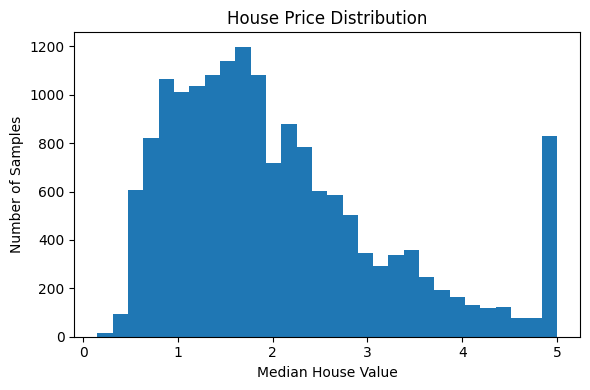

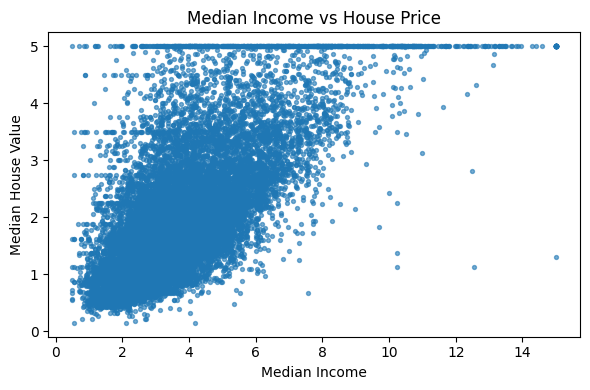

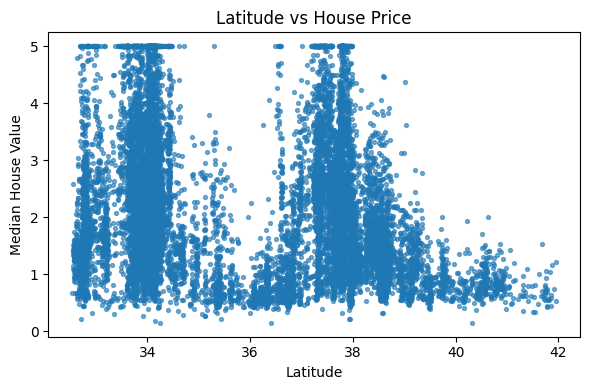

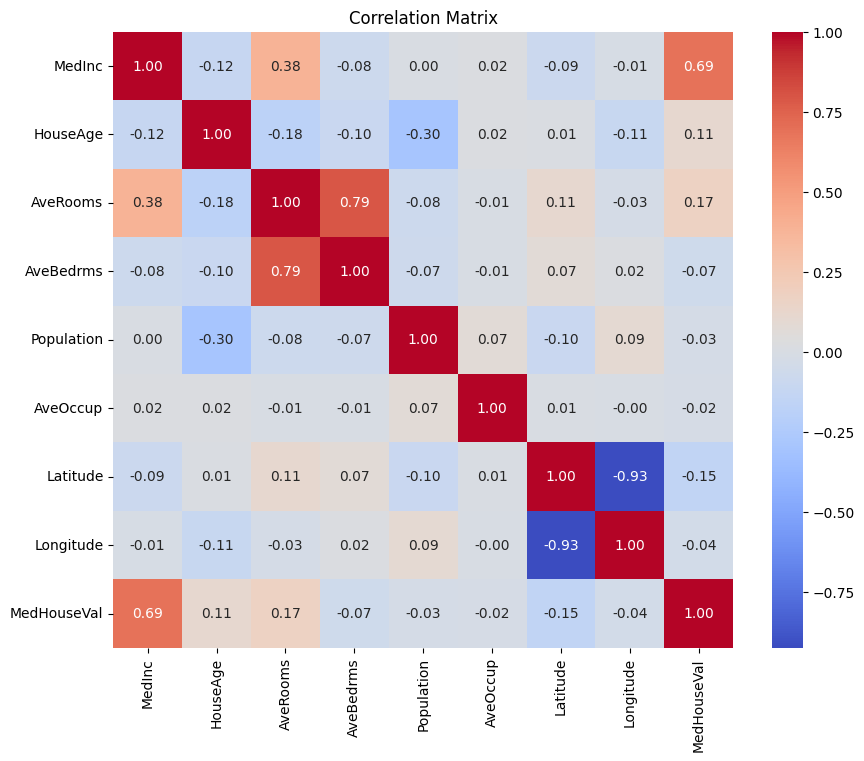

In [7]:
# הצגת התפלגות מחירי הבתים
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
plt.hist(train_df['MedHouseVal'].dropna(), bins=30)
plt.title('House Price Distribution')
plt.xlabel('Median House Value')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

# השוואת הכנסה מדדית מול מחיר הבית
plt.figure(figsize=(6,4))
plt.scatter(train_df['MedInc'], train_df['MedHouseVal'], s=8, alpha=0.6)
plt.title('Median Income vs House Price')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.tight_layout()
plt.show()

# מיקום גיאוגרפי (קו רוחב) מול מחיר הבית
plt.figure(figsize=(6,4))
plt.scatter(train_df['Latitude'], train_df['MedHouseVal'], s=8, alpha=0.6)
plt.title('Latitude vs House Price')
plt.xlabel('Latitude')
plt.ylabel('Median House Value')
plt.tight_layout()
plt.show()

# מפת חום של קורלציות
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## PART 3 – Grid Search + 5-Fold Cross Validation

In [8]:
# הפרדת מאפיינים ויעד
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

X_train = train_df.drop('MedHouseVal', axis=1)
y_train = train_df['MedHouseVal']

# בניית pipeline
pipe = Pipeline([('scaler', 'passthrough'), ('model', Ridge())])

# טווחי פרמטרים לבדיקה
param_grid = {
    'scaler': ['passthrough', StandardScaler()],
    'model__alpha': [1.0, 10.0],
    'model__fit_intercept': [True, False]
}

# קיפול נתונים ל-5 חלקים
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='r2', cv=cv, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

# הצגת התוצאות
cv_results = pd.DataFrame(grid.cv_results_)
cols = ['param_scaler','param_model__alpha','param_model__fit_intercept', 'mean_test_score','std_test_score','mean_train_score','rank_test_score']
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head())

,param_scaler,param_model__alpha,param_model__fit_intercept,mean_test_score,std_test_score,mean_train_score,rank_test_score
4,passthrough,10.0,True,0.605135,0.010603,0.606282,1
0,passthrough,1.0,True,0.605104,0.010543,0.606292,2
5,StandardScaler(),10.0,True,0.605101,0.010574,0.606282,3
1,StandardScaler(),1.0,True,0.605100,0.010540,0.606292,4
6,passthrough,10.0,False,0.546437,0.012307,0.547835,5


## PART 4 – Train Final Model

In [9]:
# אימון המודל הטוב ביותר
best_est = grid.best_estimator_
print('Best Estimator:', best_est)
best_est.fit(X_train, y_train)

Best Estimator: Pipeline(steps=[('scaler', 'passthrough'), ('model', Ridge(alpha=10.0))])


Pipeline(steps=[('scaler', 'passthrough'), ('model', Ridge(alpha=10.0))])

## PART 5 – Predict on Test & Evaluate

In [10]:
# ביצוע חיזוי והערכת ביצועים
from sklearn.metrics import r2_score

if 'MedHouseVal' in test_df.columns:
    X_test = test_df.drop('MedHouseVal', axis=1)
    y_test = test_df['MedHouseVal']
    test_pred = best_est.predict(X_test)
    test_r2 = r2_score(y_test, test_pred)
    print('R^2 on test set:', round(test_r2, 4))
else:
    X_test = test_df.copy()
    test_pred = best_est.predict(X_test)
    print('Test set has no target values; only predictions are shown')

# הצגת חמשת התחזיות הראשונות
pred_samples = pd.DataFrame({**{c: X_test[c].iloc[:5].values for c in X_test.columns}, 'y_pred': test_pred[:5]})
if 'MedHouseVal' in test_df.columns:
    pred_samples['y_true'] = y_test.iloc[:5].values
display(pred_samples)

R^2 on test set: 0.6046


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,y_pred,y_true
0,5.3254,32.0,5.786260,1.033079,982.0,2.498728,34.29,-119.27,3.094991,3.852
1,5.3032,52.0,5.095745,1.028369,980.0,3.475177,34.08,-118.12,2.948837,2.457
2,4.1679,41.0,6.617486,1.371585,915.0,2.500000,37.05,-122.05,2.861455,2.013
3,3.6429,28.0,5.249180,1.009836,848.0,2.780328,38.69,-121.41,1.438050,1.052
4,2.7457,17.0,11.183267,2.107570,675.0,2.689243,38.88,-119.99,0.330999,1.078
